# Advance Usage of RNN

In [11]:
import keras

keras.__version__

'2.2.4'

In [12]:
import os

data_dir = "./data/"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

f = open(fname)
data = f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


## A temperature forecasting problem

In [13]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i, :] = values

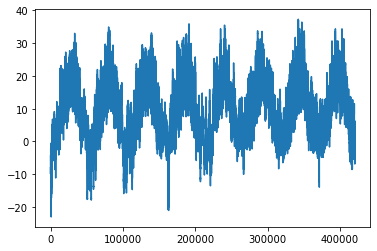

In [14]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

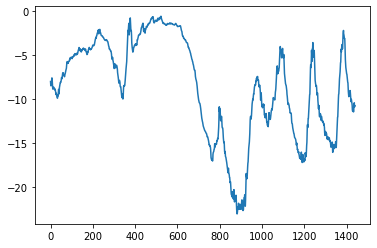

In [15]:
plt.plot(range(1440), temp[:1440])
plt.show()

## Preparing the data

In [16]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [17]:
def generator(
    data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6
):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [18]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size,
)
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size,
)
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size,
)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## A common sense, non-machine learning baseline

In [19]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))


evaluate_naive_method()

0.2897359729905486


### A basic machine learning approach

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss="mae")
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=5,
    validation_data=val_gen,
    validation_steps=val_steps,
)

Epoch 1/5
500/500 [==============================] - 52s 104ms/step - loss: 1.2548 - val_loss: 0.8182
Epoch 2/5
500/500 [==============================] - 50s 100ms/step - loss: 1.6780 - val_loss: 2.4032
Epoch 3/5
500/500 [==============================] - 45s 90ms/step - loss: 4.2013 - val_loss: 4.6209
Epoch 4/5
500/500 [==============================] - 48s 96ms/step - loss: 7.1676 - val_loss: 7.1905
Epoch 5/5
500/500 [==============================] - 48s 95ms/step - loss: 10.2021 - val_loss: 15.7167


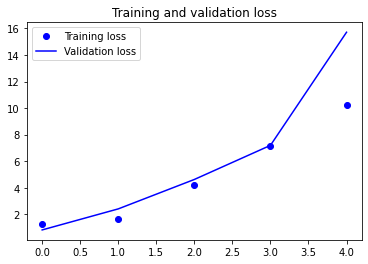

In [21]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

### A first recurrent baseline

In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss="mae")
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
500/500 [==============================] - 197s 394ms/step - loss: 0.3023 - val_loss: 0.2706
Epoch 2/20
500/500 [==============================] - 193s 386ms/step - loss: 0.2858 - val_loss: 0.2669
Epoch 3/20
500/500 [==============================] - 276s 553ms/step - loss: 0.2790 - val_loss: 0.2615
Epoch 4/20
500/500 [==============================] - 281s 562ms/step - loss: 0.2743 - val_loss: 0.2605
Epoch 5/20
500/500 [==============================] - 280s 560ms/step - loss: 0.2701 - val_loss: 0.2594
Epoch 6/20
500/500 [==============================] - 315s 631ms/step - loss: 0.2653 - val_loss: 0.2703
Epoch 7/20
500/500 [==============================] - 271s 543ms/step - loss: 0.2622 - val_loss: 0.2716
Epoch 8/20
500/500 [==============================] - 274s 548ms/step - loss: 0.2595 - val_loss: 0.2694
Epoch 9/20
500/500 [==============================] - 260s 521ms/step - lo

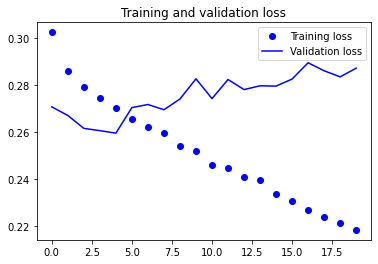

In [23]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

### Using recurrent dropout to fight overfitting

In [24]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(
    layers.GRU(
        32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])
    )
)
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss="mae")
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=5,
    validation_data=val_gen,
    validation_steps=val_steps,
)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5
500/500 [==============================] - 494s 988ms/step - loss: 0.3397 - val_loss: 0.2810
Epoch 2/5
500/500 [==============================] - 502s 1s/step - loss: 0.3152 - val_loss: 0.2742
Epoch 3/5
500/500 [==============================] - 503s 1s/step - loss: 0.3085 - val_loss: 0.2721
Epoch 4/5
500/500 [==============================] - 528s 1s/step - loss: 0.3053 - val_loss: 0.2751
Epoch 5/5
500/500 [==============================] - 582s 1s/step - loss: 0.3015 - val_loss: 0.2661


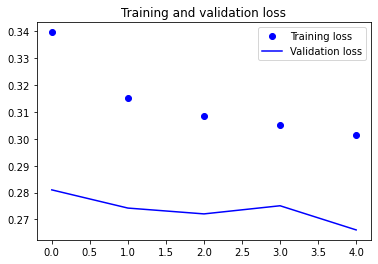

In [25]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## Stacking recurrent layers

In [26]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(
    layers.GRU(
        32,
        dropout=0.1,
        recurrent_dropout=0.5,
        return_sequences=True,
        input_shape=(None, float_data.shape[-1]),
    )
)
model.add(layers.GRU(64, activation="relu", dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss="mae")
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=5,
    validation_data=val_gen,
    validation_steps=val_steps,
)

Epoch 1/5
500/500 [==============================] - 1712s 3s/step - loss: 0.3360 - val_loss: 0.2828
Epoch 2/5
500/500 [==============================] - 1522s 3s/step - loss: 0.3138 - val_loss: 0.2806
Epoch 3/5
500/500 [==============================] - 1293s 3s/step - loss: 0.3051 - val_loss: 0.2731
Epoch 4/5
500/500 [==============================] - 1278s 3s/step - loss: 0.3020 - val_loss: 0.2697
Epoch 5/5
500/500 [==============================] - 1240s 2s/step - loss: 0.2975 - val_loss: 0.2686


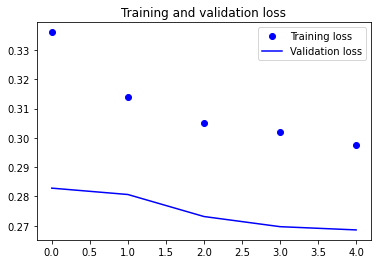

In [27]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

### Using bidirectional RNNs

In [28]:
def reverse_order_generator(
    data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6
):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets


train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size,
)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size,
)

In [29]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss="mae")
history = model.fit_generator(
    train_gen_reverse,
    steps_per_epoch=100,
    epochs=5,
    validation_data=val_gen_reverse,
    validation_steps=val_steps,
)

Epoch 1/5
500/500 [==============================] - 476s 952ms/step - loss: 0.4814 - val_loss: 0.4814
Epoch 2/5
500/500 [==============================] - 448s 895ms/step - loss: 0.4520 - val_loss: 0.4870
Epoch 3/5
500/500 [==============================] - 446s 892ms/step - loss: 0.4011 - val_loss: 0.4468
Epoch 4/5
500/500 [==============================] - 335s 669ms/step - loss: 0.3539 - val_loss: 0.4307
Epoch 5/5
500/500 [==============================] - 289s 577ms/step - loss: 0.3274 - val_loss: 0.4424


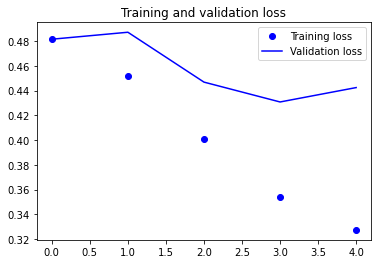

In [30]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [32]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.2)


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 354s 18ms/step - loss: 0.4845 - acc: 0.7695 - val_loss: 0.3630 - val_acc: 0.8564
Epoch 2/5
20000/20000 [==============================] - 444s 22ms/step - loss: 0.3148 - acc: 0.8783 - val_loss: 0.3264 - val_acc: 0.8686
Epoch 3/5
20000/20000 [==============================] - 444s 22ms/step - loss: 0.2532 - acc: 0.9056 - val_loss: 0.3541 - val_acc: 0.8542
Epoch 4/5
20000/20000 [==============================] - 468s 23ms/step - loss: 0.2167 - acc: 0.9204 - val_loss: 0.5009 - val_acc: 0.8486
Epoch 5/5
20000/20000 [==============================] - 458s 23ms/step - loss: 0.1934 - acc: 0.9320 - val_loss: 0.4207 - val_acc: 0.8654


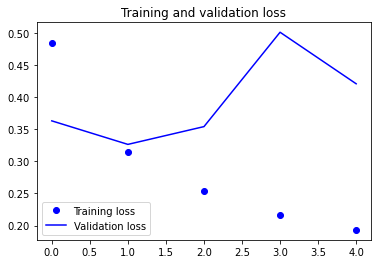

In [33]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()